# Predictive Analysis of Violent Sexual Crimes
**Emily Nguyen, Kaylynn Francisco-Nelson, Angela Iraya**

## Data Description & Cleaning
---

In [1]:
# imports/setup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv("../data/sexual_crimes_cleaned.csv") # pre-cleaned data from phase 1
df.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Time_Formatted,Hour,Time_Category,Date_Rptd,DATE_OCC,Year,Month,DayOfWeek,Reporting_Delay,Delay_Category
0,202013579,08/18/2020 12:00:00 AM,08/13/2020 12:00:00 AM,100,20,Olympic,2014,2,860,BATTERY WITH SEXUAL CONTACT,...,1:00,1,Night (0-6),2020-08-18,2020-08-13,2020,Aug,Thu,5,1-7 days
1,211907205,04/01/2021 12:00:00 AM,02/22/2020 12:00:00 AM,1,19,Mission,1915,1,122,"RAPE, ATTEMPTED",...,0:01,0,Night (0-6),2021-04-01,2020-02-22,2020,Feb,Sat,404,Over 1 year
2,221908151,04/12/2022 12:00:00 AM,10/01/2020 12:00:00 AM,1,19,Mission,1988,1,821,SODOMY/SEXUAL CONTACT B/W PENIS OF ONE PERS TO...,...,0:01,0,Night (0-6),2022-04-12,2020-10-01,2020,Oct,Thu,558,Over 1 year
3,201904093,01/02/2020 12:00:00 AM,01/02/2020 12:00:00 AM,2025,19,Mission,1901,1,121,"RAPE, FORCIBLE",...,20:25,20,Evening (18-24),2020-01-02,2020-01-02,2020,Jan,Thu,0,0-1 days
4,210708216,04/29/2021 12:00:00 AM,05/01/2020 12:00:00 AM,1330,7,Wilshire,785,1,121,"RAPE, FORCIBLE",...,13:30,13,Afternoon (12-18),2021-04-29,2020-05-01,2020,May,Fri,363,1-12 months


In [2]:
# printing column names - including transformed cols from phase 1
df.columns

Index(['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME',
       'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes',
       'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc',
       'Weapon Used Cd', 'Weapon Desc', 'Crm Cd 1', 'Crm Cd 2', 'Crm Cd 3',
       'Crm Cd 4', 'Vict Descent Full', 'Vict Age Group', 'Time_Formatted',
       'Hour', 'Time_Category', 'Date_Rptd', 'DATE_OCC', 'Year', 'Month',
       'DayOfWeek', 'Reporting_Delay', 'Delay_Category'],
      dtype='object')

In [3]:
# get the number of rows and columns
num_rows, num_cols = df.shape

print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_cols}")

Number of rows: 12371
Number of columns: 34


In [4]:
crime_counts = (
    df
    .groupby(['Crm Cd', 'Crm Cd Desc'])
    .size()
    .reset_index(name='Case_Count')
    .sort_values(by='Case_Count', ascending=False)
)

print(crime_counts)

    Crm Cd                                        Crm Cd Desc  Case_Count
10     860                        BATTERY WITH SEXUAL CONTACT        4134
0      121                                     RAPE, FORCIBLE        3739
4      815                SEXUAL PENETRATION W/FOREIGN OBJECT        1309
3      810  SEX,UNLAWFUL(INC MUTUAL CONSENT, PENETRATION W...        1072
5      820                                    ORAL COPULATION         718
6      821  SODOMY/SEXUAL CONTACT B/W PENIS OF ONE PERS TO...         527
7      822            HUMAN TRAFFICKING - COMMERCIAL SEX ACTS         456
1      122                                    RAPE, ATTEMPTED         318
2      760                    LEWD/LASCIVIOUS ACTS WITH CHILD          85
9      840  BEASTIALITY, CRIME AGAINST NATURE SEXUAL ASSLT...           7
8      830       INCEST (SEXUAL ACTS BETWEEN BLOOD RELATIVES)           6


## Representation Comparison: Baseline vs Improved
---
We compare model behavior under 2 feature representations:
- **Baseline**: Closest to Phase 1
- **Improved**: Tranformations from our Feature Representation Audit

We trained 3 models (Decision Tree, Random Forest, XGBoost), considering: 
- Accuracy, Precision, Recall, F1 (macro)
- Fiarness metrics
- Intepretability: permutation importance + SHAP for tree models


In [5]:
# imports
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import f1_score, classification_report, accuracy_score, ConfusionMatrixDisplay

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

### Baseline Models
In phase 1, we transformed some columns used in our model, including Delay_Cateogry, DayOfWeek, Vict Descent Full, Vict Age Group, and Time_Category. We used numerical features that were left untransformed, while the categorical features were one-hot encoded. 

We split the dataset 80/20 while preserving class distribution (stratify=y) to ensure each delay category is represented in both training and test sets.

In [6]:
# target feature
target = "Delay_Category"

# features that we want to use for prediction
numeric_features = [
    "Vict Age", "TIME OCC", "Hour", "Year", 
    "Part 1-2", "Rpt Dist No" # new features we want to explore
    ]
categorical_features = [
    "Month", "DayOfWeek", "Vict Sex", "Vict Descent", "Vict Age Group", 
    "AREA NAME", "Premis Desc", "Crm Cd Desc", 
    "Weapon Desc", "Weapon Used Cd",
    # new features we want to explore (including categories made in phase 1)
    "Time_Category", "DATE OCC"
]

X = df[numeric_features + categorical_features]
y = df[target].astype(str)

**Train/Test Split**

In [7]:
# train/test split before encoding
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape, " Test size:", X_test.shape)

Train size: (9896, 18)  Test size: (2475, 18)


**Preprocessing**

In [8]:
# encoding target variable to features 
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

In [9]:
# preprocessing: one-hot encode categorical, passthrough numerics
ohe = OneHotEncoder(handle_unknown="ignore")
preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", ohe, categorical_features),
    ]
)

In [10]:
# saving original (unprocesses) test data for permutation importance later
X_test_raw = X_test.copy()
y_test_enc_raw = y_test_enc.copy()

**Hyperparameter Tuning & Baseline Modeling**

In [11]:
#   - Builds a pipeline: preprocessing (preprocess) + classifier (estimator)
#   - Runs GridSearchCV with the given parameter grid and 5-fold CV, scoring by F1-macro
#   - Fits the tuned model on the training data
#   - Predicts labels on the test set
#   - Returns a dictionary with: model name, best hyperparameters found, best cross-validation F1 score, test accuracy, test F1-macro, the trained best estimator itself
def tune_and_eval(model_name, estimator, param_grid, X_train, y_train, X_test, y_test):
    pipe = Pipeline([("prep", preprocess), ("clf", estimator)])
    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring="f1_macro",
        cv=5,
        n_jobs=-1,
        verbose=0
    )
    grid.fit(X_train, y_train)
    best = grid.best_estimator_
    y_pred = best.predict(X_test)
    return {
        "model": model_name,
        "best_params": grid.best_params_
        ,
        "cv_f1_macro": grid.best_score_,
        "test_accuracy": accuracy_score(y_test, y_pred),
        "test_f1_macro": f1_score(y_test, y_pred, average="macro"),
        "estimator": best
    }

results = []

# Decision Tree
results.append(tune_and_eval(
    "DecisionTree",
    DecisionTreeClassifier(random_state=42),
    {
        "clf__criterion": ["gini", "log_loss"],
        "clf__max_depth": [5, 10, 20, None],
        "clf__min_samples_leaf": [1, 5, 10, 50],
        "clf__max_features": [None, "sqrt", "log2"],
        "clf__class_weight": [None, "balanced"],
    },
    X_train, y_train_enc, X_test, y_test_enc
))

# Random Forest
results.append(tune_and_eval(
    "RandomForest",
    RandomForestClassifier(random_state=42, n_jobs=-1),
    {
        "clf__n_estimators": [300],
        "clf__max_depth": [None, 8, 16],
        "clf__min_samples_leaf": [1, 10, 50],
        "clf__class_weight": [None, "balanced_subsample"],
    },
    X_train, y_train_enc, X_test, y_test_enc
))

# XGBoost
results.append(tune_and_eval(
    "XGBoost",
    XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'),
    {
        "clf__n_estimators": [100, 200, 300],
        "clf__max_depth": [4, 6, 8],
        "clf__learning_rate": [0.01, 0.1, 0.3],
        "clf__subsample": [0.8, 1.0],
        "clf__colsample_bytree": [0.8, 1.0],
        
    },
    X_train, y_train_enc, X_test, y_test_enc
))

C:\Users\brenn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:199: UserWarning: [13:46:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [12]:
# Build summary DataFrame
results_df = pd.DataFrame([
    {k: v for k, v in r.items() if k not in ("estimator", "best_params")}
    for r in results
]).sort_values(by="test_f1_macro", ascending=False).reset_index(drop=True)

results_df

,model,cv_f1_macro,test_accuracy,test_f1_macro
0,XGBoost,0.363175,0.539394,0.366163
1,RandomForest,0.355236,0.488889,0.325198
2,DecisionTree,0.316613,0.449293,0.296974


### Transformations
**Previously Transformed Columns from Phase 1 include:**
- Vict Descent Full
- Vict Age Group
- Time_Formatted
- Hour
- Time_Category
- Year
- Month
- DayOfWeek
- Reporting_Delay
- Delay_Category

**Transforming "Premis Desc"**
- "Premis_Category": Grouped bins by type of premises (e.g., "Residential", "Commerical/Business", etc.)

In [13]:
# Transform "Premis Desc" into high-level categories
desc_upper = df["Premis Desc"].str.upper()

conditions = [
    # Residential
    desc_upper.str.contains(r'SINGLE FAMILY DWELLING|MULTI-UNIT DWELLING|CONDOMINIUM|TOWNHOUSE|MOBILE HOME|OTHER RESIDENCE|FRAT HOUSE|DORMITORY|SRO|GROUP HOME|HOTEL|MOTEL|TRANSITIONAL HOUSING|FOSTER HOME|VACATION RENTAL', na=False),

    # Vehicle/Transportation
    desc_upper.str.contains(r'VEHICLE|AUTO|CAR|TRUCK|BUS|MTA|METROLINK|GREYHOUND|PARKING LOT|PARKING GARAGE|DRIVEWAY|GARAGE|CARPORT|TOW YARD|BUS STOP|TRAIN DEPOT|TERMINAL|STATION', na=False),

    # Public Outdoor
    desc_upper.str.contains(r'STREET|SIDEWALK|HIGHWAY|ROAD|ALLEY|FREEWAY|UNDERPASS|PARK|PLAYGROUND|BEACH|PIER|RIVER BED|VACANT LOT', na=False),

    # Commercial/Business
    desc_upper.str.contains(r'RESTAURANT|FAST FOOD|COFFEE SHOP|BAR|NIGHT CLUB|TAVERN|STORE|MARKET|MALL|SHOPPING|RETAIL|DEPARTMENT|DRUG STORE|LIQUOR|OFFICE|BUSINESS|BANK|PAWN SHOP|SWAP MEET|GAS STATION|MINI-MART|AUTO REPAIR|CAR WASH', na=False),

    # Institutional
    desc_upper.str.contains(r'SCHOOL|COLLEGE|UNIVERSITY|PRESCHOOL|DAY CARE|HOSPITAL|MEDICAL|CLINIC|NURSING|HOSPICE|METHADONE|CHURCH|SYNAGOGUE|TEMPLE|LIBRARY|MUSEUM|GOVERNMENT|POLICE|DETENTION|JAIL', na=False),

    # Entertainment/Recreation
    desc_upper.str.contains(r'ENTERTAINMENT|COMEDY CLUB|THEATRE|MOVIE|BOWLING|ARCADE|SPORTS|ARENA|STADIUM|GYM|SPA|POOL|SKATEBOARD|SEX ORIENTED|STRIP CLUB|MASSAGE PARLOR', na=False),

    # Industrial/Construction
    desc_upper.str.contains(r'CONSTRUCTION|FACTORY|WAREHOUSE|MANUFACTURING', na=False),

    # Other/Unknown
    desc_upper.str.contains(r'UNKNOWN|OTHER PREMISE|OTHER BUSINESS|OTHER/OUTSIDE', na=False)
]

choices = [
    "Residential",
    "Vehicle/Transportation",
    "Public Outdoor",
    "Commercial/Business",
    "Institutional",
    "Entertainment/Recreation",
    "Industrial/Construction",
    "Other/Unknown"
]

df["Premis_Category"] = np.select(conditions, choices, default="Other/Unknown")

print(df["Premis_Category"].value_counts())

Premis_Category
Residential                 6377
Public Outdoor              2835
Vehicle/Transportation      1365
Institutional                683
Other/Unknown                524
Commercial/Business          447
Entertainment/Recreation     116
Industrial/Construction       24
Name: count, dtype: int64


**Transforming "Weapon Desc"**
- "Weapon_Category": Consolidated individual weapon descriptions into higher-level categories to simplify interpretation and distinguish between weapon use vs. no weapon use.

In [14]:
# looking at unique values in "Weapon Desc"
df['Weapon Desc'].unique()

array(['STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)', nan,
       'UNKNOWN WEAPON/OTHER WEAPON', 'HAND GUN', 'PHYSICAL PRESENCE',
       'OTHER KNIFE', 'VERBAL THREAT', 'KNIFE WITH BLADE 6INCHES OR LESS',
       'CLUB/BAT', 'BOTTLE', 'UNKNOWN FIREARM', 'SEMI-AUTOMATIC PISTOL',
       'OTHER FIREARM', 'STICK', 'FOLDING KNIFE',
       'KNIFE WITH BLADE OVER 6 INCHES IN LENGTH', 'KITCHEN KNIFE',
       'ROPE/LIGATURE', 'AUTOMATIC WEAPON/SUB-MACHINE GUN',
       'BLUNT INSTRUMENT', 'TIRE IRON', 'SIMULATED GUN',
       'PIPE/METAL PIPE', 'FIXED OBJECT', 'SEMI-AUTOMATIC RIFLE',
       'HAMMER', 'MACE/PEPPER SPRAY', 'AXE', 'REVOLVER',
       'CAUSTIC CHEMICAL/POISON', 'SCISSORS', 'OTHER CUTTING INSTRUMENT',
       'STUN GUN', 'LIQUOR/DRUGS', 'TOY GUN',
       'HECKLER & KOCH 93 SEMIAUTOMATIC ASSAULT RIFLE', 'BOW AND ARROW',
       'MACHETE', 'DIRK/DAGGER', 'RAZOR BLADE', 'SCALDING LIQUID',
       'HECKLER & KOCH 91 SEMIAUTOMATIC ASSAULT RIFLE',
       'ROCK/THROWN OBJECT', 'BELT FLAILING I

In [15]:
# Create uppercase version to make matching easier
desc_upper = df["Weapon Desc"].str.upper()

# Define boolean masks for each category
conditions = [
    # No Weapon / Physical Force
    desc_upper.isna() | desc_upper.str.contains(r'STRONG-ARM|PHYSICAL PRESENCE|VERBAL THREAT', na=False),
    
    # Firearm
    desc_upper.str.contains(r'HAND GUN|REVOLVER|SEMI-AUTOMATIC|AUTOMATIC|OTHER FIREARM|UNKNOWN FIREARM|SIMULATED GUN|TOY GUN|HECKLER|RIFLE', na=False),
    
    # Knife / Sharp Object
    desc_upper.str.contains(r'KNIFE|DIRK|DAGGER|MACHETE|RAZOR|SCISSORS|CUTTING', na=False),
    
    # Blunt Object
    desc_upper.str.contains(r'CLUB|BAT|STICK|PIPE|TIRE IRON|HAMMER|ROCK|BELT|CHAIN|BLUNT|FIXED OBJECT|BOTTLE', na=False),
    
    # Chemical / Explosive / Other
    desc_upper.str.contains(r'MACE|PEPPER SPRAY|CAUSTIC|POISON|SCALDING|LIQUOR|DRUGS|BOW|ARROW|OTHER WEAPON|ROPE|LIGATURE|AXE|STUN GUN', na=False)
]

# Define labels corresponding to the above conditions
choices = [
    "No Weapon, Physical Force",
    "Firearm",
    "Knife, Sharp Object",
    "Blunt Object",
    "Chemical, Explosive, Other"
]

# Apply transformation
df["Weapon_Category"] = np.select(conditions, choices, default="Other/Unknown")

# Verify transformation
print(df["Weapon_Category"].value_counts())


Weapon_Category
No Weapon, Physical Force     11675
Chemical, Explosive, Other      427
Firearm                         134
Knife, Sharp Object             106
Blunt Object                     29
Name: count, dtype: int64


### Improved Models

In [16]:
# target feature
target = "Delay_Category"

# features that we want to use for prediction
numeric_features = [
    "Hour", "Year", 
    "Part 1-2", "Rpt Dist No"
]
categorical_features = [
    "Vict Sex", "Vict Descent Full", "Vict Age Group", 
    "AREA NAME", "Premis_Category",
    "Crm Cd Desc", "Weapon_Category",
    "Month", "DayOfWeek", "Time_Category", 
]

X = df[numeric_features + categorical_features]
y = df[target].astype(str)

**Train/Test Split**

In [17]:
# train/test split before encoding
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape, " Test size:", X_test.shape)


Train size: (9896, 14)  Test size: (2475, 14)


In [18]:
# encoding target variable to features 
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

**Preprocessing**

In [19]:
# preprocessing: one-hot encode categorical, passthrough numerics
ohe = OneHotEncoder(handle_unknown="ignore")
preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", ohe, categorical_features),
    ]
)

**Improved Modeling**

In [20]:
improved_results = []

# Decision Tree
improved_results.append(tune_and_eval(
    "DecisionTree",
    DecisionTreeClassifier(random_state=42),
    {
        "clf__criterion": ["gini", "log_loss"],
        "clf__max_depth": [5, 10, 20, None],
        "clf__min_samples_leaf": [1, 5, 10, 50],
        "clf__max_features": [None, "sqrt", "log2"],
        "clf__class_weight": [None, "balanced"],
    },
    X_train, y_train_enc, X_test, y_test_enc
))

# Random Forest
improved_results.append(tune_and_eval(
    "RandomForest",
    RandomForestClassifier(random_state=42, n_jobs=-1),
    {
        "clf__n_estimators": [300],
        "clf__max_depth": [None, 8, 16],
        "clf__min_samples_leaf": [1, 10, 50],
        "clf__class_weight": [None, "balanced_subsample"],
    },
    X_train, y_train_enc, X_test, y_test_enc
))

# XGBoost
improved_results.append(tune_and_eval(
    "XGBoost",
    XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'),
    {
        "clf__n_estimators": [100, 200, 300],
        "clf__max_depth": [4, 6, 8],
        "clf__learning_rate": [0.01, 0.1, 0.3],
        "clf__subsample": [0.8, 1.0],
        "clf__colsample_bytree": [0.8, 1.0],
    },
    X_train, y_train_enc, X_test, y_test_enc
))

C:\Users\brenn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:199: UserWarning: [13:55:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In the improved models:
- **XGBoost** achieved the highest test accuracy (0.512) and comparable F1-macro, indicating better overall generalization.  
- **Random Forest** had a slightly higher test F1-macro, but test accuracy was lower.  
- **Decision Tree** performed the worst across all metrics, highlighting the benefit of ensemble methods for this dataset.  

**Interpretation of Results:**  
XGBoost is the best-performing model overall, balancing predictive performance and stability. This suggests that the improved feature representations helped ensemble models capture meaningful patterns in the data more effectively. However, we will dig deeper into the RandomForest's performance as it is easier to interpret for fairness.

In [21]:
# Build summary DataFrame
improved_results_df = pd.DataFrame([
    {k: v for k, v in r.items() if k not in ("estimator", "best_params")}
    for r in improved_results
]).sort_values(by="test_f1_macro", ascending=False).reset_index(drop=True)

improved_results_df

,model,cv_f1_macro,test_accuracy,test_f1_macro
0,RandomForest,0.340637,0.448889,0.341383
1,XGBoost,0.342133,0.511515,0.340527
2,DecisionTree,0.299678,0.449697,0.288670


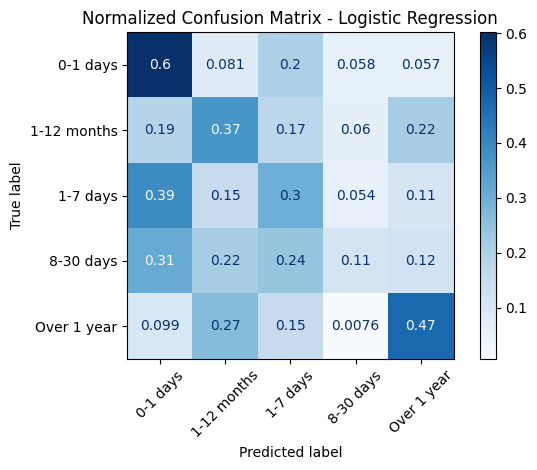

In [44]:
# Confusion Matrix for Improved Random Forest
"""
best_rf = improved_results[1]['estimator']
y_pred = best_rf.predict(X_test)

fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(y_test_enc, y_pred, ax=ax, cmap="Blues", colorbar=False)
plt.title("Confusion Matrix - Improved Random Forest")
plt.tight_layout()
plt.show()
"""
# extracting random forest estimator from the trained pipeline 
cm_model =  improved_results[1]['estimator']

ConfusionMatrixDisplay.from_estimator(
    cm_model, 
    X_test, 
    y_test_enc,
    display_labels=le.classes_, 
    cmap='Blues',
    normalize='true'  # shows proportions instead of counts
)
plt.title("Normalized Confusion Matrix - Logistic Regression")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Comparitive Results

We focus on Random Forest because it provides a good balance of predictive performance, interpretability, and fairness analysis. XGBoost had a slightly higher F1, but it is harder to interpret for fairness analysis. 

**Fairness Evaluation by Subgroup**

We evaluate how the improved Random Forest model performs across key demographic subgroups:
- Vict Descent Full (victim race/ethnicity)
- Vict Sex (victim gender)
- Vict Age Group (age categories)

By computing **accuracy, false positive rate (FPR), false negative rate (FNR), and disparity ratios** per subgroup, we can identify differences in model behavior and assess fairness. Large differences across groups may indicate potential bias in the model.

**Interpretation of Results**:
Model performance is not uniform across demographic groups, suggesting uneven predictive fairness.

- **Race/Ethnicity**: Accuracy is highest for victims categorized as “Other” (0.50) and lowest for White victims (0.40). The Asian group shows the most concern, with an FNR of 1.00, meaning the model fails to identify any true positives for this group.
- **Gender**: Female victims are predicted more accurately (0.46) than male victims (0.38), though disparities are relatively small.
- **Age**: The largest gaps occur by age. Children (FPR = 0.45) and adolescents (FPR = 0.64) experience overprediction, while adults (FNR = 0.88) and older adults (FNR = 0.70) face underprediction. This indicates significant age-related bias in the model’s performance.

In [23]:
# fairness measurement with accuracy, FPR, FNR, disparity ratios
from sklearn.metrics import confusion_matrix, accuracy_score

# Fairness: subgroup performance metrics
improved_rf_pipeline = improved_results[1]['estimator']

subgroup_features = ['Vict Descent Full', 'Vict Sex', 'Vict Age Group']
fairness_results = []

for feature in subgroup_features:
    metrics = []
    
    for group in X_test[feature].unique():
        mask = X_test[feature] == group
        if mask.sum() == 0:
            continue
        
        X_group = X_test[mask]
        y_true_group = y_test_enc[mask]
        y_pred_group = improved_rf_pipeline.predict(X_group)
        
        # Compute confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_true_group, y_pred_group, labels=[0, 1]).ravel()
        
        # Compute metrics
        acc = accuracy_score(y_true_group, y_pred_group)
        fpr = fp / (fp + tn) if (fp + tn) > 0 else np.nan
        fnr = fn / (fn + tp) if (fn + tp) > 0 else np.nan
        
        metrics.append({
            "Feature": feature,
            "Group": group,
            "Accuracy": acc,
            "FPR": fpr,
            "FNR": fnr
        })
    
    # Compute disparity ratios (relative to lowest FPR/FNR, highest accuracy)
    df = pd.DataFrame(metrics)
    df["Accuracy Disparity"] = df["Accuracy"] / df["Accuracy"].max()
    df["FPR Disparity"] = df["FPR"].min() / df["FPR"]
    df["FNR Disparity"] = df["FNR"].min() / df["FNR"]
    
    fairness_results.append(df)

# Combine all subgroup results
fairness_df = pd.concat(fairness_results, ignore_index=True)

fairness_df

,Feature,Group,Accuracy,FPR,FNR,Accuracy Disparity,FPR Disparity,FNR Disparity
0,Vict Descent Full,Black,0.454724,0.110000,0.527778,0.903386,0.606061,0.531009
1,Vict Descent Full,Hispanic,0.459916,0.139535,0.280255,0.913699,0.477778,1.000000
2,Vict Descent Full,White,0.402135,0.094340,0.363636,0.798909,0.706667,0.770701
3,Vict Descent Full,Other,0.503356,0.107143,0.333333,1.000000,0.622222,0.840764
4,Vict Descent Full,Asian,0.478873,0.066667,1.000000,0.951362,1.000000,0.280255
5,Vict Sex,F,0.455837,0.117188,0.336364,1.000000,1.000000,1.000000
6,Vict Sex,M,0.378378,0.140625,0.350000,0.830074,0.833333,0.961039
7,Vict Age Group,Children (0-12),0.296089,0.454545,0.000000,0.592179,0.037745,NaN
8,Vict Age Group,Adults (25-49),0.500000,0.017157,0.880952,1.000000,1.000000,0.000000
9,Vict Age Group,Young Adults (18-24),0.483801,0.029851,0.970588,0.967603,0.574755,0.000000


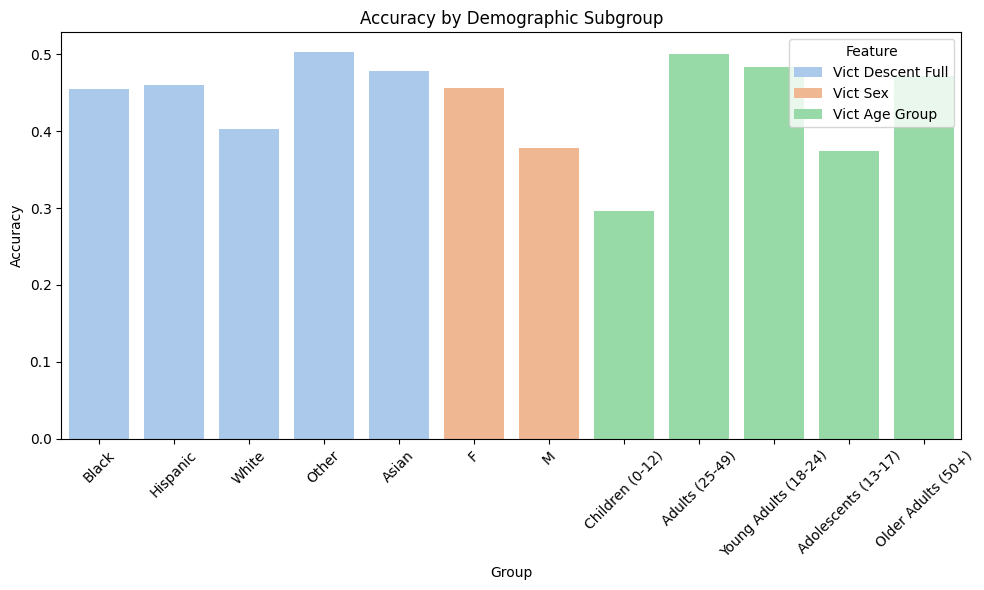

In [ ]:
# Fairness Visualization: Accuracy by Group
plt.figure(figsize=(10,6))
sns.barplot(data=fairness_df, x="Group", y="Accuracy", hue="Feature", palette="pastel")
plt.title("Accuracy by Demographic Subgroup")
plt.xlabel("Group")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.legend(title="Feature")
plt.tight_layout()
plt.show()

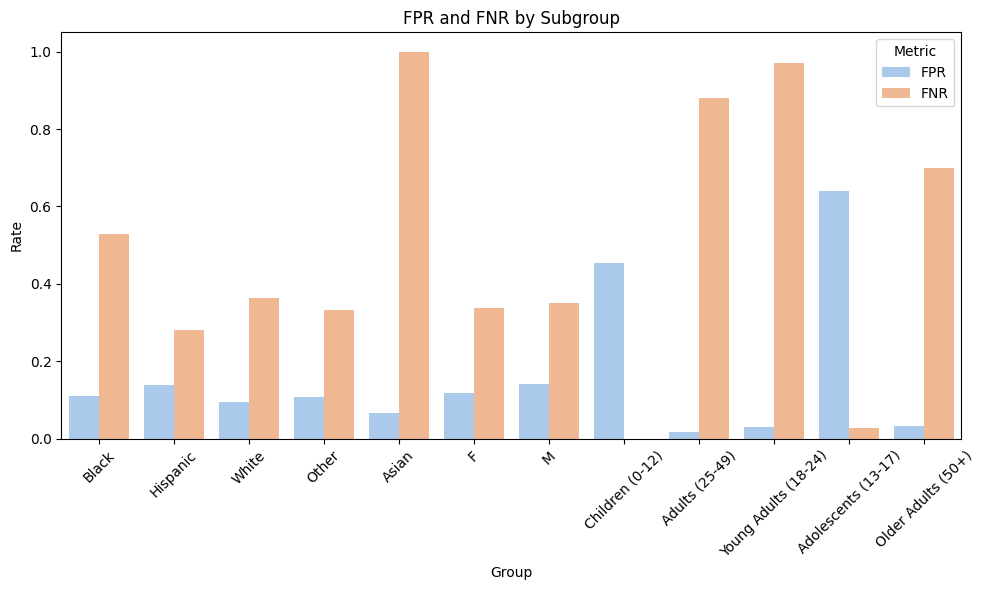

In [ ]:
# Fairness Visualization: FPR & FNR bar chart
metrics_long = fairness_df.melt(
    id_vars=["Feature", "Group"],
    value_vars=["FPR", "FNR"],
    var_name="Metric",
    value_name="Value"
)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(
    data=metrics_long,
    x="Group",
    y="Value",
    hue="Metric",
    palette="pastel"
)
plt.title("FPR and FNR by Subgroup")
plt.xlabel("Group")
plt.ylabel("Rate")
plt.xticks(rotation=45)
plt.legend(title="Metric")
plt.tight_layout()
plt.show()

**Feature Importance**

To better understand how model improvements affected predictive power, we compared the top 10 most important features from the baseline Random Forest model and the improved Random Forest using permutation importance. Feature importances can sometimes be biased towards numerical features and those with many unique values, so using permutation importance can provide a fairer and more accurate view since it shows how each feature impacts predictions rather than how often it was used. 

**Interpretation of Results**:
- The improved model shows stronger overall feature importance values and more meaningful relationships. Particularily, Vict Age Group, Premis_Category, and Time_Category became much more influential, showing that preprocessing can help simplify and clarify the patterns in the data.
- Raw or overly detailed features like Vic Age and Premis Desc became less relevant once they were replaced with cleaned or grouped verison. 
- Time-related features such as Year, Month, and Hour remained significant, but this might be due to bias of our target feature of reporting delays, which is also used in a temporal context. 

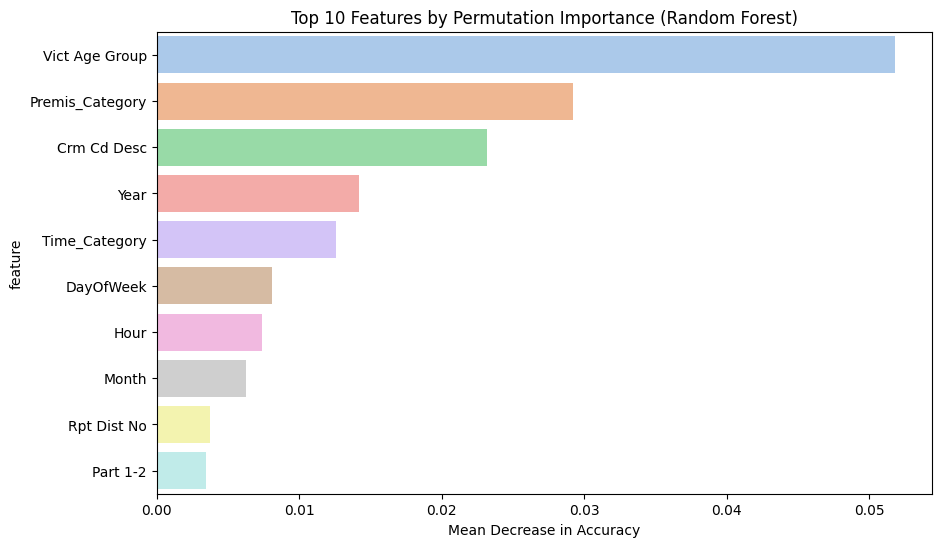

In [ ]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(
    improved_rf_pipeline, X_test, y_test_enc, n_repeats=10, random_state=42
)

importance_df = pd.DataFrame({
    "feature": X_test.columns,
    "importance_mean": perm_importance.importances_mean,
    "importance_std": perm_importance.importances_std
}).sort_values(by="importance_mean", ascending=False)

# Plot top 10 features
plt.figure(figsize=(10,6))
sns.barplot(x="importance_mean", y="feature", data=importance_df.head(10), hue="feature", palette="pastel")
plt.title("Top 10 Features by Permutation Importance (Random Forest)")
plt.xlabel("Mean Decrease in Accuracy")
plt.show()

In [ ]:
# Top 10 most important features from baseline Random Forest vs improved Random Forest
# Baseline Random Forest
baseline_rf = results[1]['estimator']  # adjust index if needed
baseline_perm = permutation_importance(
    baseline_rf, X_test_raw, y_test_enc_raw, n_repeats=10, random_state=42
)
baseline_importance = pd.DataFrame({
    "feature": X_test_raw.columns,
    "importance_mean": baseline_perm.importances_mean
}).sort_values(by="importance_mean", ascending=False).head(10)

# Improved Random Forest
improved_rf = improved_results[1]['estimator']
improved_perm = permutation_importance(
    improved_rf, X_test, y_test_enc, n_repeats=10, random_state=42
)
improved_importance = pd.DataFrame({
    "feature": X_test.columns,
    "importance_mean": improved_perm.importances_mean
}).sort_values(by="importance_mean", ascending=False).head(10)

# Combine for comparison
comparison_df = pd.DataFrame({
    "Baseline Top 10 Features": baseline_importance["feature"].values,
    "Baseline Importance": baseline_importance["importance_mean"].values,
    "Improved Top 10 Features": improved_importance["feature"].values,
    "Improved Importance": improved_importance["importance_mean"].values
})

print("\nFeature Importance Comparison (Top 10)\n")
print(comparison_df.to_string(index=False))


Feature Importance Comparison (Top 10)

Baseline Top 10 Features  Baseline Importance Improved Top 10 Features  Improved Importance
                Vict Age             0.006465           Vict Age Group             0.051798
             Premis Desc             0.003556          Premis_Category             0.029212
             Rpt Dist No             0.001899              Crm Cd Desc             0.023152
                    Year             0.001172                     Year             0.014222
                DATE OCC             0.001010            Time_Category             0.012566
             Crm Cd Desc             0.000768                DayOfWeek             0.008081
               DayOfWeek             0.000727                     Hour             0.007394
           Time_Category            -0.000162                    Month             0.006263
                Vict Sex            -0.000646              Rpt Dist No             0.003717
          Weapon Used Cd            -0.